In [3]:
from tqdm import tqdm
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
import os
import numpy as np
import pandas as pd

In [4]:
print(tf.__version__)
print(tf.test.is_gpu_available())

1.13.1
False


In [5]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.set_random_seed(7)

In [6]:
train = pd.read_csv('./data/train.csv', encoding = 'utf-8', header = 1, index_col = 'id')
test = pd.read_csv('./data/test.csv', encoding = 'utf-8', index_col = 'id')
print(train.head())
print(test.head())
print(len(train))

    X00    X01  X02  X03  X04     X05    X06   X07     X08     X09  ...  Y09  \
id                                                                  ...        
0   9.7  988.8  1.2  0.6  0.0  1009.3  989.6  12.2  1009.9  1009.8  ...  7.0   
1   9.3  988.9  1.7  1.9  0.0  1009.3  989.6  12.1  1010.0  1009.9  ...  6.5   
2   9.4  989.0  1.1  2.3  0.0  1009.2  989.7  12.1  1010.1  1010.1  ...  6.5   
3   9.4  988.9  1.5  0.7  0.0  1009.2  989.6  12.0  1010.0  1010.0  ...  6.0   
4   9.2  988.9  0.8  1.7  0.0  1009.2  989.7  12.0  1010.1  1010.0  ...  6.0   

    Y10  Y11  Y12   Y13  Y14  Y15  Y16  Y17  Y18  
id                                                
0   7.5  7.0  9.0  10.0  9.5  9.0  8.0  9.0  NaN  
1   7.5  7.0  8.5  10.0  9.5  9.0  7.5  9.0  NaN  
2   7.5  6.5  8.0   9.5  9.5  8.5  7.5  8.5  NaN  
3   7.0  6.0  8.0   9.5  9.0  8.5  7.5  8.5  NaN  
4   7.0  6.0  7.5   9.5  9.0  8.5  7.5  8.5  NaN  

[5 rows x 59 columns]
       X00    X01  X02  X03  X04     X05    X06   X07     X

In [7]:
train.describe()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
count,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,...,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,432.000000
mean,20.227904,988.621107,1.509764,1.453157,1.270223,1008.333902,989.005093,21.658081,1008.790341,1008.394171,...,22.222801,23.737269,24.649653,23.641898,20.926157,21.319444,21.564468,22.969097,23.381829,26.687500
std,4.707570,3.359916,1.071858,0.936151,4.429852,3.395037,3.403714,4.377216,3.520317,3.546180,...,9.112299,10.599000,12.214870,8.400081,6.106031,7.066149,6.810084,8.054272,9.275172,6.286621
min,8.300000,977.300000,0.000000,0.000000,0.000000,997.200000,978.100000,11.600000,997.300000,996.300000,...,3.500000,4.000000,3.000000,6.000000,7.500000,7.500000,7.000000,6.000000,7.000000,18.500000
25%,16.900000,986.800000,0.700000,0.800000,0.000000,1006.500000,987.100000,18.400000,1006.700000,1006.300000,...,15.500000,15.500000,15.000000,17.000000,16.500000,16.500000,16.500000,16.500000,16.000000,21.000000
50%,19.900000,988.600000,1.300000,1.300000,0.000000,1008.500000,989.100000,21.200000,1008.800000,1008.400000,...,20.000000,20.500000,21.000000,22.000000,19.500000,19.500000,20.000000,21.500000,20.000000,25.000000
75%,24.100000,991.000000,2.100000,2.000000,0.000000,1010.800000,991.600000,24.825000,1011.400000,1010.900000,...,30.500000,32.500000,34.500000,30.500000,25.000000,25.000000,27.000000,30.000000,32.000000,31.500000
max,30.900000,997.200000,10.200000,5.800000,25.600000,1016.800000,997.400000,32.700000,1017.500000,1018.000000,...,42.000000,49.000000,53.000000,43.500000,38.000000,42.500000,40.500000,41.500000,43.500000,41.500000


In [9]:
#33일은 4752행, 30일은 4320행까지. 30~33일치 사이는 4320 id부터 4751 id까지.
#Y18의 3일치와 X31, X32는 상관성이 높음
#X31, X32
X_train = train.loc[4320:4751, 'X31':'X32']
X_train2 = X_train.reset_index(drop = True)

In [7]:
#X31과 X32의 평균값으로 재설정(추후 weight 조정해서 재계산 가능)
X_train['mean'] = (X_train['X31']+X_train['X32'])/(2)
    #X_train[i]['mean'] = np.mean(X_train[i]['X31'], X_train[i]['X32'])
X_train = X_train['mean'].reset_index(drop = True)

In [10]:
#index 새로 부여한 데이터 생성
y18 = train[~train['Y18'].isnull()]['Y18'].reset_index(drop= True)

In [9]:
print(len(X_train))
print(len(y18))

432
432


In [10]:
X_train

0      18.35
1      18.35
2      18.30
3      18.40
4      18.45
       ...  
427    18.40
428    18.45
429    18.50
430    18.50
431    18.60
Name: mean, Length: 432, dtype: float64

In [11]:
y18

0      20.5
1      20.5
2      20.5
3      20.5
4      20.5
       ... 
427    21.5
428    21.5
429    21.5
430    21.5
431    21.0
Name: Y18, Length: 432, dtype: float64

In [22]:
print(type(X_train))
print(type(y18))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [23]:
X = np.array(X_train)
print(type(X))
print(X)

<class 'numpy.ndarray'>
[18.35 18.35 18.3  18.4  18.45 18.5  18.55 18.5  18.6  18.5  18.5  18.35
 18.3  18.5  18.35 18.2  18.2  18.2  18.1  17.85 17.9  17.85 17.8  17.9
 17.9  17.9  17.85 17.75 17.75 17.8  17.85 18.   18.05 18.15 18.2  18.3
 18.45 18.7  18.85 19.   19.1  19.45 19.75 19.8  20.15 20.2  20.7  20.95
 20.75 21.15 21.45 21.45 22.   21.95 21.7  21.75 22.05 22.55 22.5  22.25
 22.75 23.3  23.25 23.35 23.65 23.2  24.4  24.2  24.25 24.95 24.6  24.7
 25.25 25.6  25.55 25.8  25.75 26.7  26.1  26.2  26.45 26.7  27.4  27.35
 27.25 27.25 27.75 27.85 27.65 27.55 27.7  27.7  27.55 28.1  28.25 28.4
 28.55 28.3  28.25 28.25 28.2  28.05 28.1  27.8  27.45 27.6  27.3  27.15
 26.8  26.55 26.7  26.4  26.25 25.95 25.7  25.55 25.3  24.8  24.15 24.
 23.95 23.65 23.3  23.25 22.95 22.85 22.7  22.6  22.2  22.35 22.2  21.8
 21.65 21.5  21.35 21.35 21.25 21.45 21.35 21.2  20.8  20.9  20.55 20.45
 20.7  20.55 20.35 20.35 20.3  19.8  19.9  20.   20.   19.75 19.45 19.55
 19.75 19.85 19.8  19.85 19.8  19.

In [11]:
X = np.array(X_train2)
print(type(X))
print(X)

<class 'numpy.ndarray'>
[[18.  18.7]
 [17.7 19. ]
 [17.4 19.2]
 [17.5 19.3]
 [17.4 19.5]
 [17.4 19.6]
 [17.3 19.8]
 [17.3 19.7]
 [17.5 19.7]
 [17.4 19.6]
 [17.5 19.5]
 [17.3 19.4]
 [17.1 19.5]
 [17.4 19.6]
 [17.1 19.6]
 [16.8 19.6]
 [16.7 19.7]
 [16.7 19.7]
 [16.6 19.6]
 [16.4 19.3]
 [16.6 19.2]
 [16.6 19.1]
 [16.6 19. ]
 [16.8 19. ]
 [16.9 18.9]
 [16.9 18.9]
 [16.8 18.9]
 [16.6 18.9]
 [16.6 18.9]
 [16.7 18.9]
 [16.8 18.9]
 [17.  19. ]
 [17.1 19. ]
 [17.3 19. ]
 [17.4 19. ]
 [17.5 19.1]
 [17.7 19.2]
 [18.1 19.3]
 [18.3 19.4]
 [18.5 19.5]
 [18.7 19.5]
 [19.1 19.8]
 [19.4 20.1]
 [19.5 20.1]
 [19.9 20.4]
 [19.8 20.6]
 [20.3 21.1]
 [20.6 21.3]
 [20.8 20.7]
 [21.1 21.2]
 [21.6 21.3]
 [21.6 21.3]
 [22.6 21.4]
 [22.1 21.8]
 [21.7 21.7]
 [21.7 21.8]
 [21.9 22.2]
 [22.1 23. ]
 [22.5 22.5]
 [22.3 22.2]
 [22.7 22.8]
 [23.1 23.5]
 [22.7 23.8]
 [22.6 24.1]
 [23.  24.3]
 [22.9 23.5]
 [24.1 24.7]
 [23.6 24.8]
 [23.3 25.2]
 [24.7 25.2]
 [24.4 24.8]
 [24.1 25.3]
 [24.9 25.6]
 [25.5 25.7]
 [25.6 25.5]
 

In [12]:
Y = np.array(y18)
print(type(Y))
print(Y)

<class 'numpy.ndarray'>
[20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5 20.5
 20.5 20.5 20.  20.  20.  19.5 19.  19.  19.  19.  19.  19.  19.  19.
 19.  19.  19.  19.  18.5 18.5 19.  19.  19.5 19.5 20.  20.  20.5 20.5
 21.  21.5 22.  23.5 24.5 25.5 27.  28.5 28.  27.  26.  25.5 25.5 25.
 25.5 25.5 25.5 26.  26.  27.  27.5 27.5 28.5 30.  29.5 29.5 29.  30.5
 33.5 35.5 35.  36.  37.  37.5 38.  37.  37.5 37.  36.5 36.  35.5 36.
 36.5 37.  35.5 33.5 32.5 32.  31.5 31.5 31.  31.  31.  31.5 31.5 31.5
 31.5 31.5 31.5 31.  30.5 30.5 30.  30.  29.5 29.5 29.  28.5 28.5 28.5
 28.  28.  27.5 27.5 27.  26.5 26.5 26.  25.5 25.5 25.  25.  24.5 24.5
 24.5 24.  24.  23.5 23.5 23.  23.  23.  22.5 22.5 22.5 22.5 22.5 22.
 22.  22.  22.  22.  22.  22.  22.  21.5 21.5 21.5 21.5 21.  21.  21.
 21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.
 20.5 20.5 20.5 20.  20.  19.5 19.5 19.5 20.  20.  20.  20.5 20.5 20.5
 21.  21.  21.5 21.5 22.  22.  22.5 23.  23.5 24.  24.  24.

In [13]:
# loss가 4미만으로 떨어지면 학습 종료 시키는 기능
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 4):
            print('\n Loss is under 4, cancelling training')
            self.model.stop_training = True

In [14]:
callbacks = myCallback()

In [15]:
from sklearn.model_selection import train_test_split

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [17]:
print(x_train.shape)
print(y_train.shape)

(345, 2)
(345,)


In [115]:
x_train = x_train.reshape((345, 1, 1))
print(x_train.shape)

(345, 1, 1)


In [18]:
x_train

array([[20.8, 22.5],
       [28.2, 28.8],
       [17. , 19. ],
       [27.4, 27.1],
       [19.2, 19.2],
       [19.6, 19.6],
       [27.7, 27.8],
       [18.8, 19.9],
       [27.2, 28.5],
       [26.3, 25.4],
       [24.3, 24.8],
       [17.4, 19.6],
       [19.8, 20.6],
       [20.5, 20.6],
       [21.9, 21.5],
       [27.3, 27. ],
       [21. , 20.8],
       [16.7, 19.7],
       [24.1, 22.7],
       [20.8, 22.8],
       [26.8, 27.3],
       [17.5, 19.3],
       [16.6, 19.6],
       [21. , 21.9],
       [22.7, 22.8],
       [25.8, 24.7],
       [24.4, 25.2],
       [22.6, 24.1],
       [26.6, 26.8],
       [20.9, 20.5],
       [24.1, 23.5],
       [16.7, 18.9],
       [26.9, 28. ],
       [23.5, 23.2],
       [17.8, 18.1],
       [16.8, 18.9],
       [17.3, 19.7],
       [20.6, 21.2],
       [22.2, 23.8],
       [26.8, 26.8],
       [28.3, 27.8],
       [25.9, 25.5],
       [21.7, 21.2],
       [23.5, 24.8],
       [25.7, 25.7],
       [20. , 18.8],
       [23.6, 24.4],
       [17.2,

In [21]:
print(X.shape)

(432, 2)


In [34]:
#2가지 column 사용(X31, X32)
X = X.reshape(432, 1, 2)
Y = Y.reshape(432, 1, 1)
print(x_train.shape)
print(y_train.shape)

(345, 1, 2)
(345, 1, 1)


In [116]:
y_train = y_train.reshape((345,1, 1))

In [38]:
#data_dim = 1
#timesteps = 1
data_dim = x_train.shape[-1]
timesteps = x_train.shape[-2]

In [39]:
print(data_dim, timesteps)

2 1


In [44]:
print(x_train.shape)
y_train = y_train.reshape(345,)
print(y_train.shape)

(345, 1, 2)
(345,)


In [123]:
x_test = x_test.reshape((87,1, 1))
y_test = y_test.reshape((87,1, 1))

In [40]:
model = Sequential()
model.add(LSTM(128,  return_sequences=False, input_shape=(timesteps, data_dim)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [41]:
model.compile(optimizer='adam',
              loss='mse')

In [45]:
# 모델 학습
model.fit(    
    x_train, y_train,
    epochs=600,
    batch_size=8,
    verbose=2,
    shuffle=False,
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/600
 - 1s - loss: 318.4225
Epoch 2/600
 - 0s - loss: 26.4894
Epoch 3/600
 - 0s - loss: 15.9785
Epoch 4/600
 - 0s - loss: 11.3435
Epoch 5/600
 - 0s - loss: 10.4182
Epoch 6/600
 - 0s - loss: 10.0570
Epoch 7/600
 - 0s - loss: 9.9062
Epoch 8/600
 - 0s - loss: 9.7750
Epoch 9/600
 - 0s - loss: 9.7024
Epoch 10/600
 - 0s - loss: 9.6326
Epoch 11/600
 - 0s - loss: 9.5610
Epoch 12/600
 - 0s - loss: 9.5244
Epoch 13/600
 - 0s - loss: 9.5078
Epoch 14/600
 - 0s - loss: 9.4813
Epoch 15/600
 - 0s - loss: 9.4544
Epoch 16/600
 - 0s - loss: 9.4376
Epoch 17/600
 - 0s - loss: 9.4048
Epoch 18/600
 - 0s - loss: 9.3877
Epoch 19/600
 - 0s - loss: 9.3836
Epoch 20/600
 - 0s - loss: 9.3534
Epoch 21/600
 - 0s - loss: 9.3063
Epoch 22/600
 - 0s - loss: 9.3092
Epoch 23/600
 - 0s - loss: 9.3104
Epoch 24/600
 - 0s - loss: 9.2916
Epoch 25/600
 - 0s - loss: 9.2593
Epoch 26/600
 - 0s - loss: 9.2476
Epoch 27/600
 - 0s - loss: 9.2424
Epoch 28/600
 - 0s - loss: 9.1909
Ep

Epoch 230/600
 - 0s - loss: 7.6692
Epoch 231/600
 - 0s - loss: 7.7098
Epoch 232/600
 - 0s - loss: 7.7551
Epoch 233/600
 - 0s - loss: 7.8113
Epoch 234/600
 - 0s - loss: 7.7442
Epoch 235/600
 - 0s - loss: 7.6769
Epoch 236/600
 - 0s - loss: 7.8471
Epoch 237/600
 - 0s - loss: 7.7029
Epoch 238/600
 - 0s - loss: 7.6804
Epoch 239/600
 - 0s - loss: 7.6664
Epoch 240/600
 - 0s - loss: 7.9116
Epoch 241/600
 - 0s - loss: 7.7183
Epoch 242/600
 - 0s - loss: 7.6896
Epoch 243/600
 - 0s - loss: 7.6184
Epoch 244/600
 - 0s - loss: 7.6194
Epoch 245/600
 - 0s - loss: 7.8719
Epoch 246/600
 - 0s - loss: 7.7213
Epoch 247/600
 - 0s - loss: 7.6949
Epoch 248/600
 - 0s - loss: 7.8725
Epoch 249/600
 - 0s - loss: 7.7095
Epoch 250/600
 - 0s - loss: 7.7574
Epoch 251/600
 - 0s - loss: 7.6818
Epoch 252/600
 - 0s - loss: 7.6088
Epoch 253/600
 - 0s - loss: 7.6550
Epoch 254/600
 - 0s - loss: 7.6922
Epoch 255/600
 - 0s - loss: 7.6088
Epoch 256/600
 - 0s - loss: 7.6245
Epoch 257/600
 - 0s - loss: 7.8631
Epoch 258/600
 - 0s 

Epoch 464/600
 - 0s - loss: 7.4039
Epoch 465/600
 - 0s - loss: 7.2627
Epoch 466/600
 - 0s - loss: 7.3142
Epoch 467/600
 - 0s - loss: 6.9154
Epoch 468/600
 - 0s - loss: 6.9819
Epoch 469/600
 - 0s - loss: 7.1000
Epoch 470/600
 - 0s - loss: 7.0305
Epoch 471/600
 - 0s - loss: 7.0339
Epoch 472/600
 - 0s - loss: 7.3612
Epoch 473/600
 - 0s - loss: 7.3691
Epoch 474/600
 - 0s - loss: 6.9474
Epoch 475/600
 - 0s - loss: 7.0186
Epoch 476/600
 - 0s - loss: 7.0708
Epoch 477/600
 - 0s - loss: 6.9736
Epoch 478/600
 - 0s - loss: 6.9151
Epoch 479/600
 - 0s - loss: 7.5237
Epoch 480/600
 - 0s - loss: 7.2498
Epoch 481/600
 - 0s - loss: 7.3886
Epoch 482/600
 - 0s - loss: 7.2953
Epoch 483/600
 - 0s - loss: 6.9832
Epoch 484/600
 - 0s - loss: 7.2919
Epoch 485/600
 - 0s - loss: 7.2682
Epoch 486/600
 - 0s - loss: 7.2971
Epoch 487/600
 - 0s - loss: 6.9493
Epoch 488/600
 - 0s - loss: 7.2579
Epoch 489/600
 - 0s - loss: 7.1611
Epoch 490/600
 - 0s - loss: 7.3404
Epoch 491/600
 - 0s - loss: 6.9959
Epoch 492/600
 - 0s 

In [48]:
y_test = y_test.reshape(87,)

In [49]:
score = model.evaluate(x_test, y_test, verbose = 1)

87/87 [==============================] - ETA:  - 0s 2ms/step


In [50]:
print(score)

4.312990843564615


In [128]:
X_pre = train.loc[0:4320, 'X31':'X32']
X_pre['mean'] = (X_pre['X31']+X_pre['X32'])/(2)
X_pre = X_pre['mean'].reset_index(drop = True)

In [131]:
X_pre30 = np.array(X_pre)

In [133]:
X_pre30 = X_pre30.reshape(4321, 1, 1)

In [134]:
y_pred = model.predict(X_pre30)

In [135]:
print(y_pred)

[[[12.838042]]

 [[12.70976 ]]

 [[12.322598]]

 ...

 [[20.319237]]

 [[20.018314]]

 [[20.068653]]]


In [138]:
len(y_pred)

4321

In [51]:
X_post = test.loc[4752:16271, 'X31':'X32']
X_post['mean'] = (X_post['X31']+X_post['X32'])/(2)
X_post = X_post['mean'].reset_index(drop = True)
X_post80 = np.array(X_post)

In [53]:
X_post = test.loc[4752:16271, 'X31':'X32'].reset_index(drop = True)
X_post80 = np.array(X_post)

In [57]:
print(X_post80.shape)
X_post80 = X_post80.reshape(11520, 1, 2)
y_pred802 = model.predict(X_post80)
y802_submit = pd.DataFrame({'id':range(4752, 16272),
              'Y18':y_pred802.reshape(1,-1)[0]})
y802_submit.to_csv('0411상관관계_80일치결과2.csv', index = False)

(11520, 2, 1)


In [156]:
X_post80 = X_post80.reshape(11520, 1, 1)
y_pred80 = model.predict(X_post80)

In [139]:
# 제출 파일 만들기
submit4 = pd.DataFrame({'id':range(0, 4321),
              'Y18':y_pred.reshape(1,-1)[0]})

In [158]:
y80_submit = pd.DataFrame({'id':range(4752, 16272),
              'Y18':y_pred80.reshape(1,-1)[0]})

In [146]:
submit4.to_csv('0411상관관계테스트.csv', index = False)

In [159]:
y80_submit.to_csv('0411상관관계_80일치결과.csv', index = False)

In [141]:
submit4.head()

,id,Y18
0,0,12.838042
1,1,12.709760
2,2,12.322598
3,3,12.063215
4,4,11.932869


No handles with labels found to put in legend.


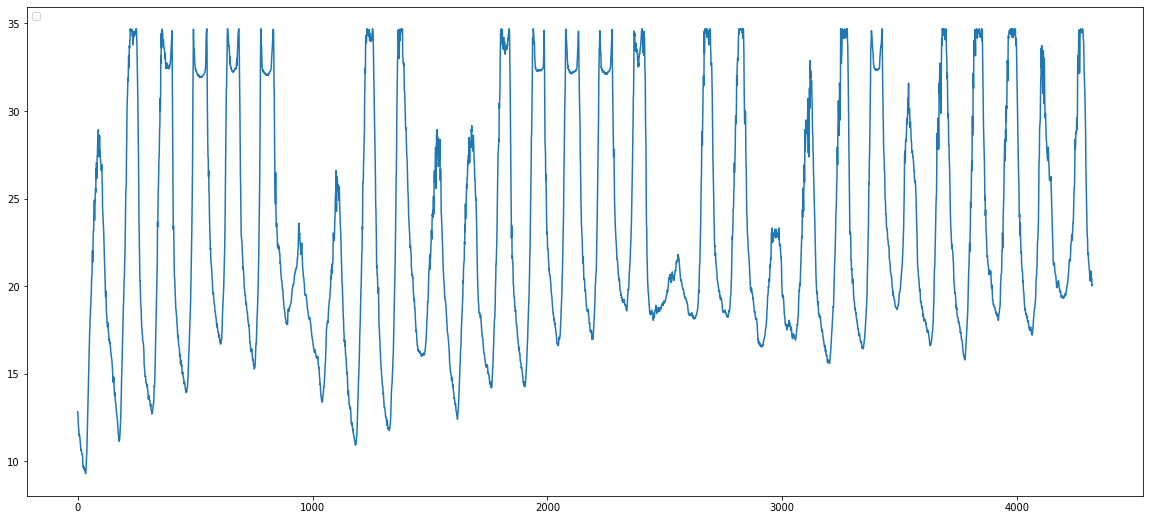

In [147]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 9))
plt.plot(submit4['Y18'])
plt.legend(loc='upper left')
plt.show()

In [58]:
baseline = pd.read_csv('baseline_result.csv')
y80_submit = pd.read_csv('0411상관관계_80일치결과.csv')

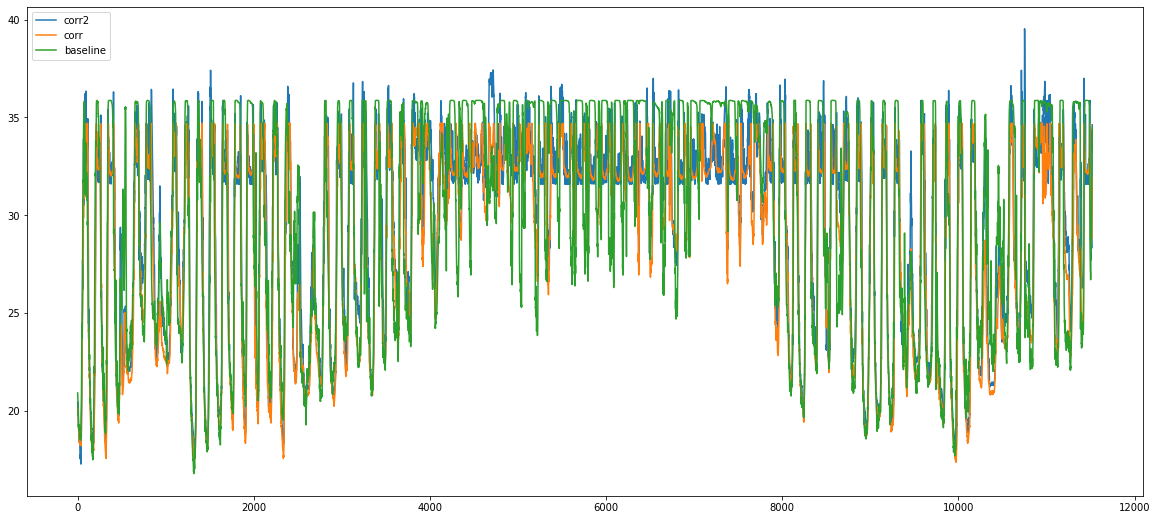

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 9))
plt.plot(y802_submit['Y18'])
plt.plot(y80_submit['Y18'])
plt.plot(baseline['Y18'])
plt.legend(['corr2','corr', 'baseline'], loc='upper left')
plt.show()